In [10]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import mu, get_velocity_profile, oh_to_12pluslog
load_style_sheet("papers")
print(sys.version_info)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [11]:
outputs = [
    "../outputs/constant/vgas-1",
    "../outputs/constant/vgas-1-centraloutflow"
    # "../outputs/linear/dvdr-0p1",
    # "../outputs/linear/dvdr-0p1-centraloutflow"
]
outputs = [vice.output(name) for name in outputs]

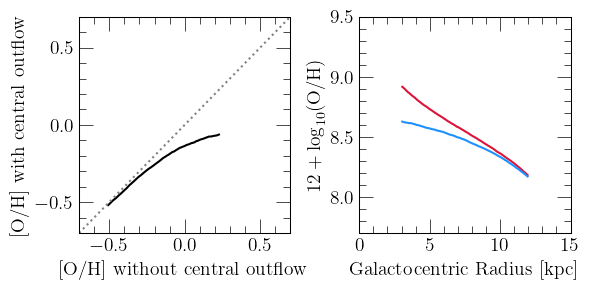

In [13]:
fig = plt.figure(figsize = (6, 3))
ax1 = fig.add_subplot(121)
ax1.set_xlabel(r"[O/H] without central outflow")
ax1.set_ylabel(r"[O/H] with central outflow")
ax1.set_xlim([-0.7, 0.7])
ax1.set_ylim(ax1.get_xlim())

ax2 = fig.add_subplot(122)
ax2.set_xlabel(r"Galactocentric Radius [kpc]")
ax2.set_ylabel(r"$12 + \log_{10}$(O/H)")
ax2.set_xlim([0, 15])
ax2.set_ylim([7.7, 9.5])

zone_width = 0.1
lookback = 0
start = int(3 / zone_width)
stop = int(12 / zone_width)
diff = [abs(_ - lookback) for _ in outputs[0].zones["zone0"].history["lookback"]]
idx = diff.index(min(diff))
radii = [zone_width * (i + 0.5) for i in range(len(outputs[0].zones.keys()))]
oh0 = [outputs[0].zones["zone%d" % (i)].history["[o/h]"][idx] for i in range(len(radii))]
# oh0 = [_ - 0.2 for _ in oh0]
oh1 = [outputs[1].zones["zone%d" % (i)].history["[o/h]"][idx] for i in range(len(radii))]
ax1.plot(oh0[start:stop], oh1[start:stop], c = named_colors()["black"])
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), c = named_colors()["grey"], linestyle = ":")

oh0 = [oh_to_12pluslog(oh) for oh in oh0]
oh1 = [oh_to_12pluslog(oh) for oh in oh1]
ax2.plot(radii[start:stop], oh0[start:stop], c = named_colors()["crimson"])
ax2.plot(radii[start:stop], oh1[start:stop], c = named_colors()["dodgerblue"])

plt.tight_layout()
plt.show()

In [3]:
# output = vice.output("../outputs/river/test-fine")
# output = vice.output("../outputs/amd/test")
output = vice.output("../outputs/angular-momentum-dilution/betaphiin0p7-oscil-0p25-0p2Gyr-skew5")
# output = vice.output("../outputs/river/test")
# output = vice.output("../outputs/linear/dvdr-0p05")

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_73531/1073287571.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


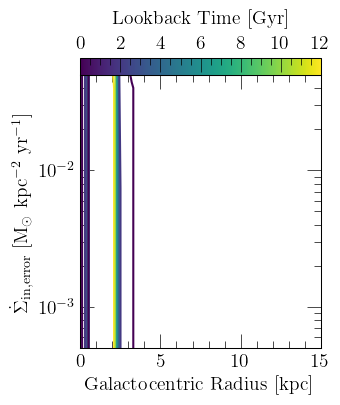

In [7]:
LOOKBACKS = [0.01, 2, 4, 6, 8, 10, 12][::-1]
COLORMAP = "viridis"

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot \Sigma_\text{in,error}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax.set_yscale("log")
ax.set_xlim([0, 15])
ax.set_ylim([5.e-4, 0.05])

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal")
cbar.set_label("Lookback Time [Gyr]", labelpad = 8)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12])

def plot_snapshot(output, lookback, zone_width = 0.1, **kwargs):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, mu_gas, mu_o = mu(output, lookback, zone_width = zone_width)
    else:
        radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
        mu_gas = len(radii) * [0.]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    err = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        area = np.pi * ((radii[i] + zone_width)**2 - radii[i]**2)
        try:
            dmgdt = (zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]) / (
                zone.history["lookback"][idx] - zone.history["lookback"][idx + 1]) * 1.e-9
        except:
            print(idx)
            print(len(zone.history["mgas"]))
            raise
        if zone.history["sfr"][idx]:
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            eta = 0
        expected = dmgdt + zone.history["sfr"][idx] * (1 + eta -
            mu_gas[i] - zone.history["R_eff"][idx])
        expected /= area
        actual = zone.history["ifr"][idx] / area
        err.append(expected - actual)
        # err.append(actual - expected)
#         err.append(dmgdt)
#         err.append(expected)
        # err.append(actual)
#         if err[-1] > 0.01: print(actual, expected)
    ax.plot(radii[:-1], err, **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i])
    }
    plot_snapshot(output, LOOKBACKS[i], **kwargs)

plt.tight_layout()
cbar_ax.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.05
])
plt.show()

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_73531/3124961456.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


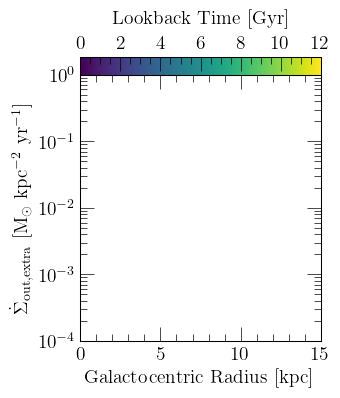

In [4]:
LOOKBACKS = [0.0, 2, 4, 6, 8, 10, 12][::-1]
COLORMAP = "viridis"

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot \Sigma_\text{out,extra}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax.set_xlim([0, 15])
ax.set_yscale("log")
ax.set_ylim([1.e-4, 1])

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal")
cbar.set_label("Lookback Time [Gyr]", labelpad = 8)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12])

def plot_snapshot(output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [(i + 0.5) * zone_width for i in range(len(output.zones.keys()))]
    sigma_out_extra = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        expected = zone.history["eta_0"][idx] * zone.history["sfr"][idx]
        actual = zone.history["ofr"][idx]
        sigma_out_extra.append(actual - expected)
    ax.plot(radii, sigma_out_extra, **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i])
    }
    plot_snapshot(output, LOOKBACKS[i], **kwargs)

plt.tight_layout()
cbar_ax.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.05
])
plt.show()

0.0
1.480189
-5.378112303479876
1.9981776900004435
18.774771510541594


/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_73531/3411007907.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


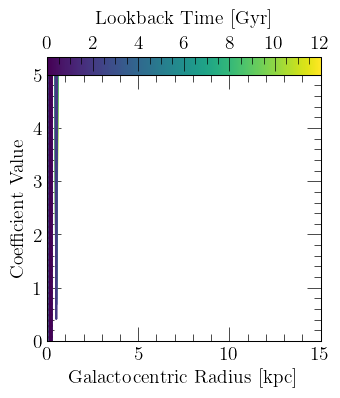

In [8]:
LOOKBACKS = [0.01, 2, 4, 6, 8, 10, 12][::-1]
COLORMAP = "viridis"

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"Coefficient Value")
ax.set_xlim([0, 15])
ax.set_ylim([0, 5])

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal")
cbar.set_label("Lookback Time [Gyr]", labelpad = 8)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12])

def plot_error(output, lookback, zone_width = 0.1, **kwargs):
    radii, mu_gas, mu_o = mu(output, lookback, zone_width = zone_width)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    yvals = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            taustar = float("nan")
        dlnmgdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
        dlnmgdt /= zone.history["mgas"][idx] 
        dlnmgdt /= zone.history["time"][idx + 1] - zone.history["time"][idx]
        y = 1 + eta - zone.history["R_eff"][idx]
        y -= mu_gas[i]
        y += taustar * dlnmgdt
        yvals.append(y)
        if lookback < 0.5 and i == 1:
            print(zone.history["eta_0"][idx])
            print(zone.history["R_eff"][idx])
            print(mu_gas[i])
            print(taustar)
            print(dlnmgdt)
#     print(yvals)
    ax.plot(radii[:-1], yvals, linestyle = "-", **kwargs)
    ax.plot(radii[:-1], [-y for y in yvals], linestyle = ":", **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {"c": cmap.to_rgba(LOOKBACKS[i])} 
    plot_error(output, LOOKBACKS[i], zone_width = 1, **kwargs)

plt.tight_layout()
cbar_ax.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.05
])
plt.show()

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_73531/3965455069.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


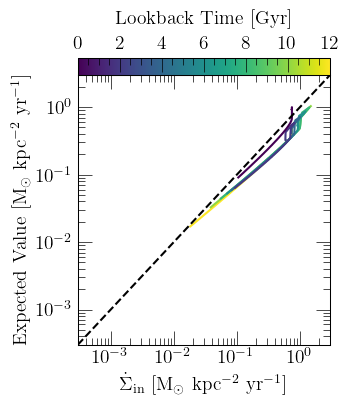

In [17]:
LOOKBACKS = [0.00, 2, 4, 6, 8, 10, 12][::-1]
COLORMAP = "viridis"

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
# ax.set_xlabel(r"$\dot \Sigma_\text{flow}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax.set_xlabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax.set_ylabel(r"Expected Value [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([3.e-4, 3])
ax.set_ylim(ax.get_xlim())

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal")
cbar.set_label("Lookback Time [Gyr]", labelpad = 8)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12])

def plot_comparison(output, lookback, zone_width = 0.1, **kwargs):
    radii, mu_gas, mu_o = mu(output, lookback, zone_width = zone_width)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    expected = []
    actual = []
#     for i in range(len(radii) - 1):
    for i in range(30, 150):
        zone = output.zones["zone%d" % (i)]
        area = np.pi * ((radii[i] + zone_width)**2 - radii[i]**2)
        dmgdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
        dmgdt /= zone.history["time"][idx + 1] - zone.history["time"][idx]
        dmgdt /= 1.e9
#         eta = zone.history["eta_0"][idx]
        eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        recycling = zone.history["R_eff"][idx]
        
        # river
#         exp = dmgdt + zone.history["sfr"][idx] * (1 + eta - recycling)
#         act = mu_gas[i] * zone.history["sfr"][idx]
        
        # amd
        exp = dmgdt + zone.history["sfr"][idx] * (1 + eta - mu_gas[i] - recycling)
        act = zone.history["ifr"][idx]
        
        expected.append(exp / area)
        actual.append(act / area)
    ax.plot(actual, expected, **kwargs)
#     ax.scatter(actual, expected, **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i]),
#         "s": 1,
    }
    plot_comparison(output, LOOKBACKS[i], **kwargs)
    
vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
ax.plot(vals, vals, c = named_colors()["black"], linestyle = "--")

plt.tight_layout()
cbar_ax.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.05
])
plt.show()